# We start off with training only 4 out of the 4803 characters we have

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import PIL.Image
from matplotlib import pyplot as plt

### Look for installed font so that Chinese characters can be shown in Matplotlib

In [2]:
!fc-list :lang=zh

/System/Library/Fonts/STHeiti Medium.ttc: Heiti SC,黑體\-簡,黒体\-簡,Heiti\-간체,黑体\-简:style=Medium,中黑,Halbfett,Normaali,Moyen,Medio,ミディアム,중간체,Médio,Средний,Normal,中等,Media
/System/Library/Fonts/PingFang.ttc: PingFang TC,蘋方\-繁,苹方\-繁:style=Regular,標準體,常规体
/System/Library/Fonts/PingFang.ttc: PingFang SC,蘋方\-簡,苹方\-简:style=Regular,標準體,常规体
/System/Library/Fonts/PingFang.ttc: PingFang HK,蘋方\-港,苹方\-港:style=Regular,標準體,常规体
/System/Library/Fonts/STHeiti Light.ttc: Heiti TC,黑體\-繁,黒体\-繁,Heiti\-번체,黑体\-繁:style=Light,細體,Mager,Fein,Ohut,Fin,Leggero,ライト,가는체,Licht,Tynn,Leve,Светлый,细体,Fina
/System/Library/Fonts/Supplemental/Songti.ttc: Songti SC,宋體\-簡,宋体\-简:style=Light,細體,细体
/System/Library/Fonts/Supplemental/Songti.ttc: Songti TC,宋體\-繁,宋体\-繁:style=Regular,標準體,常规体
/System/Library/Fonts/Supplemental/Songti.ttc: Songti SC,宋體\-簡,宋体\-简:style=Regular,標準體,常规体
/System/Library/Fonts/PingFang.ttc: .PingFang SC,.蘋方\-簡,.苹方\-简:style=Medium,中黑體,中黑体
/System/Library/Fonts/PingFang.ttc: .PingFang HK,.蘋方\-港,.苹方\-港:style=Medium

In [30]:
from matplotlib.font_manager import FontProperties
plt.rcParams['font.family'] = ['Heiti TC'] # change default family to one that can show Chinese characters
plt.rcParams['axes.unicode_minus'] = False  # in case minus sign is shown as box

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  
from tensorflow.keras.optimizers import Adam

### Specify relevant raw, training, and testing data route

In [5]:
raw_data_path = '/Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_characters_cleaned'
training_data_path = '/Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_training_data_xwzj/'
testing_data_path = '/Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_testing_data_xwzj/'

os.chdir(raw_data_path)
print( 'Current working directory:', os.getcwd() ) 

Current working directory: /Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_characters_cleaned


---

### Here we pick only 4 out of 4803 to train on. 學無止境 means endless / lifelong learning (is the purpose of life)

In [6]:
selected_chars = [ '學', '無', '止', '境' ]

### We create our training directories from the raw dataset 

In [7]:
os.chdir(raw_data_path)
try: 
    os.mkdir(training_data_path) 

except:
    shutil.rmtree(training_data_path)
    os.mkdir(training_data_path) 

finally: 
    for char in selected_chars:
        shutil.copytree(raw_data_path+'/'+char, training_data_path+'/'+char )

In [8]:
os.getcwd()

'/Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_characters_cleaned'

---

### Let's visualize a sample data

In [25]:
img_list = []
for char in selected_chars : 
    folder_path = training_data_path+'/'+char
    file_names = os.listdir(folder_path)
    for i in range(8):
        img_list.append(folder_path+'/'+file_names[i])

In [10]:
img_list[:3]

['/Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_training_data_xwzj//學/學_8.png',
 '/Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_training_data_xwzj//學/學_22.png',
 '/Users/derryzrli/Downloads/data_dsi_capstone/traditional_chinese_training_data_xwzj//學/學_36.png']

### Sample Data

{'無', '止', '境', '學'}


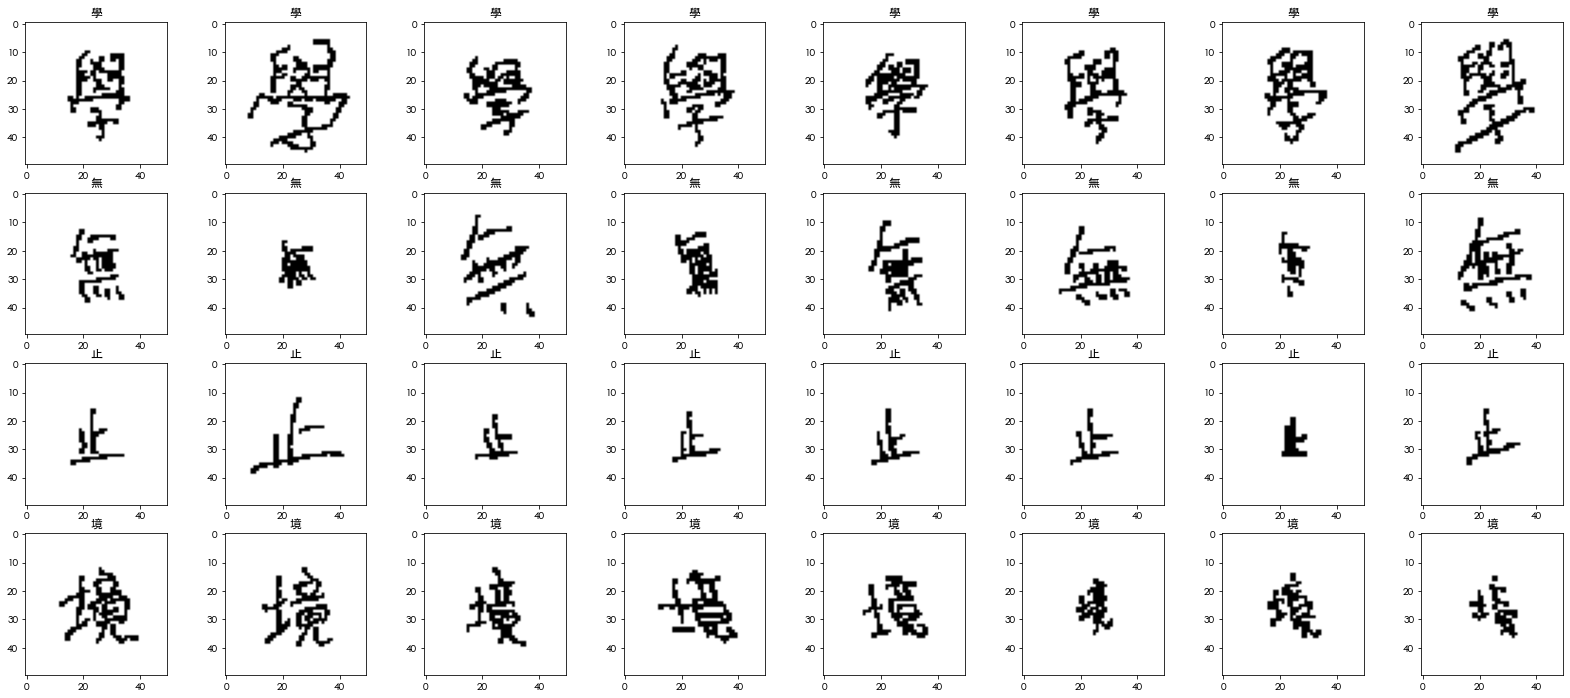

In [26]:
l = []
for i in range(32):      
    plt.subplot(4,8,i+1)
    title = img_list[i].split('/')[-1].split('_')[0]
    
    plt.gcf().set_size_inches((28,12)) 
    img = load_img(img_list[i])  
    img = tf.constant(np.array(img))
    plt.imshow(img)
    plt.title(title)
    l.append(title)
print(set(l))

----

### Data Augmentation - since we are limited in data size (around 200 entries in total)

#### Training Set

In [12]:
train_data_gen = ImageDataGenerator(rescale = 1./255, 
                                    validation_split = 0.2,
                                    width_shift_range = 0.05,   
                                    height_shift_range = 0.05,
                                    zoom_range = 0.1)

In [13]:
train_gen = train_data_gen.flow_from_directory(training_data_path,
                                               target_size = (50,50),
                                               batch_size = 8,
                                               class_mode = 'categorical',
                                               subset = 'training'
                                              )

Found 163 images belonging to 4 classes.


#### Testing Set

In [14]:
test_data_gen = ImageDataGenerator(rescale = 1./255, 
                                    validation_split = 0.2)

In [15]:
test_gen = test_data_gen.flow_from_directory(training_data_path,
                                             target_size = (50,50),
                                             batch_size = 8,
                                             class_mode = 'categorical',
                                             subset = 'validation')

Found 40 images belonging to 4 classes.


In [16]:
test_gen[0][0].shape

(8, 50, 50, 3)

### Construct the CNN Sequential Model

In [17]:
model = Sequential() 
model.add(
    Conv2D(filters=5, 
           kernel_size=(2,2), 
           activation='relu', 
           padding='same',
           input_shape=(50,50,3),
          )
)

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(
     Conv2D(filters=5, 
            kernel_size=(2,2), 
            activation='relu', 
            padding='same',
           )
)

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dropout(rate=0.5))

model.add(Dense(512, activation='relu'))

model.add(Dense(len(selected_chars), activation='softmax'))


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 5)         65        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 5)         105       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 5)         0         
_________________________________________________________________
flatten (Flatten)            (None, 720)               0         
_________________________________________________________________
dropout (Dropout)            (None, 720)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               3

### Compile the model

In [27]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

### Fit and training the model

In [28]:
history = model.fit(train_gen, validation_data=test_gen, epochs=50)

2022-06-12 18:22:06.734422: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/50
21/21 [==============================] - 1s 29ms/step - loss: 1.5066 - accuracy: 0.1694 - val_loss: 1.2582 - val_accuracy: 0.5250
Epoch 2/50
21/21 [==============================] - 0s 7ms/step - loss: 1.2713 - accuracy: 0.4910 - val_loss: 1.1128 - val_accuracy: 0.4250
Epoch 3/50
21/21 [==============================] - 0s 7ms/step - loss: 1.1348 - accuracy: 0.5243 - val_loss: 0.7981 - val_accuracy: 0.8000
Epoch 4/50
21/21 [==============================] - 0s 7ms/step - loss: 0.8447 - accuracy: 0.7074 - val_loss: 0.5941 - val_accuracy: 0.8500
Epoch 5/50
21/21 [==============================] - 0s 7ms/step - loss: 0.7905 - accuracy: 0.7095 - val_loss: 0.7343 - val_accuracy: 0.6500
Epoch 6/50
21/21 [==============================] - 0s 7ms/step - loss: 0.6238 - accuracy: 0.7090 - val_loss: 0.5843 - val_accuracy: 0.7000
Epoch 7/50
21/21 [==============================] - 0s 7ms/step - loss: 0.6137 - accuracy: 0.7670 - val_loss: 0.4202 - val_accuracy: 0.8750
Epoch 8/50
21/21 [=

### Save the model for later usage in Gradio app

In [29]:
os.chdir(training_data_path)
model.save('CNN_model_xwzj.h5')

### Save the history info to track accuracy and loss

In [22]:
import pickle

In [23]:
with open('./trainHistoryDictSmall', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
my_dict = pickle.load(open('./trainHistoryDictSmall', 'rb'))
my_dict

{'loss': [1.3951925039291382,
  1.3510103225708008,
  1.2686742544174194,
  1.0668572187423706,
  0.9181104898452759,
  0.7270591259002686,
  0.7103355526924133,
  0.5061095356941223,
  0.5021745562553406,
  0.49753978848457336,
  0.4122496545314789,
  0.3649044334888458,
  0.36760979890823364,
  0.4779359698295593,
  0.44965314865112305,
  0.3420692980289459,
  0.4014631509780884,
  0.3457720875740051,
  0.36278092861175537,
  0.3113242983818054,
  0.4007573127746582,
  0.3057495653629303,
  0.25796520709991455,
  0.3454796075820923,
  0.34925058484077454,
  0.2833201587200165,
  0.26530417799949646,
  0.2586514353752136,
  0.23502382636070251,
  0.31407222151756287,
  0.24519824981689453,
  0.27372896671295166,
  0.22381320595741272,
  0.19084672629833221,
  0.2946109175682068,
  0.3236703872680664,
  0.2216426134109497,
  0.2033231556415558,
  0.2669587731361389,
  0.26477840542793274,
  0.2560177743434906,
  0.260825514793396,
  0.23559364676475525,
  0.2346249669790268,
  0.216785